# 📈 Week 6 Trading Strategy: Factor Models

---

## 🎯 Strategy Overview

**Building on Weeks 1-5 + Adding Week 6 Concepts:**
- Foundation concepts (returns, volatility, correlation)
- Statistical analysis (distributions, hypothesis testing)
- Time series analysis (stationarity, GARCH)
- ML foundations (regression, regularization)
- Portfolio optimization (MPT, efficient frontier)
- **NEW:** CAPM (Capital Asset Pricing Model)
- **NEW:** Fama-French 3-Factor Model
- **NEW:** Fama-French 5-Factor Model
- **NEW:** Alpha & Beta analysis

**Strategy Logic:**
1. Calculate factor exposures (betas)
2. Identify alpha-generating stocks
3. Construct factor-neutral portfolio
4. Generate trading signals from factor analysis

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
# Tech stocks: AAPL, GOOGL, MSFT | Finance stocks: GS, JPM
TICKERS = ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 3
RISK_FREE_RATE = 0.05  # Annual

print("=" * 60)
print("📊 WEEK 6 TRADING STRATEGY: FACTOR MODELS")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Using Factor Models: CAPM, FF3, FF5")

📊 WEEK 6 TRADING STRATEGY: FACTOR MODELS

🎯 Analyzing: ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
📅 Using Factor Models: CAPM, FF3, FF5


In [2]:
# ============================================================
# DATA LOADING & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch stock data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading stock data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading stock data...
✅ Loaded 756 trading days


In [3]:
# ============================================================
# SIMULATED FACTOR DATA (FF3 & FF5)
# ============================================================
# Note: In production, use actual FF data from Ken French's website

print("\n📥 Creating factor data (simulated based on market data)...")

# Market excess return
rf_daily = RISK_FREE_RATE / 252
market_return = returns[BENCHMARK] - rf_daily

# Simulate SMB, HML, RMW, CMA based on market dynamics
np.random.seed(42)
smb = pd.Series(np.random.normal(0.0002, 0.006, len(market_return)), 
                index=market_return.index, name='SMB')  # Small minus Big
hml = pd.Series(np.random.normal(0.0001, 0.005, len(market_return)), 
                index=market_return.index, name='HML')  # High minus Low (Value)
rmw = pd.Series(np.random.normal(0.00015, 0.004, len(market_return)), 
                index=market_return.index, name='RMW')  # Robust minus Weak
cma = pd.Series(np.random.normal(0.0001, 0.003, len(market_return)), 
                index=market_return.index, name='CMA')  # Conservative minus Aggressive

# Add some correlation with market
smb = smb + 0.15 * market_return
hml = hml - 0.2 * market_return
rmw = rmw + 0.1 * market_return
cma = cma - 0.1 * market_return

factors = pd.DataFrame({
    'Mkt-RF': market_return,
    'SMB': smb,
    'HML': hml,
    'RMW': rmw,
    'CMA': cma,
    'RF': rf_daily
})

print("✅ Factor data created")
print(f"   Factors: Mkt-RF, SMB, HML, RMW, CMA")


📥 Creating factor data (simulated based on market data)...
✅ Factor data created
   Factors: Mkt-RF, SMB, HML, RMW, CMA


---

## 📊 Section 1: CAPM Analysis (Week 6 Concept)

**Capital Asset Pricing Model:**
$$R_i - R_f = \alpha + \beta (R_m - R_f) + \epsilon$$

**Interpretation:**
- **α (Alpha):** Excess return not explained by market risk
- **β (Beta):** Sensitivity to market movements
- **β > 1:** More volatile than market
- **β < 1:** Less volatile than market

In [4]:
# ============================================================
# CAPM ANALYSIS
# ============================================================

print("📊 CAPM ANALYSIS")
print("=" * 80)

capm_results = {}

for ticker in TICKERS:
    # Excess returns
    excess_return = returns[ticker] - rf_daily
    
    # CAPM regression
    X = factors[['Mkt-RF']].values
    y = excess_return.values
    
    model = LinearRegression()
    model.fit(X, y)
    
    alpha = model.intercept_ * 252  # Annualized
    beta = model.coef_[0]
    
    # R-squared
    y_pred = model.predict(X)
    r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)
    
    # T-statistics
    n = len(y)
    residuals = y - y_pred
    se_alpha = np.sqrt(np.sum(residuals**2) / (n - 2)) * np.sqrt(252)
    X_centered = X - X.mean()
    se_beta = np.sqrt(np.sum(residuals**2) / (n - 2)) / np.sqrt(np.sum(X_centered**2))
    t_alpha = (alpha) / se_alpha if se_alpha > 0 else 0
    t_beta = beta / se_beta if se_beta > 0 else 0
    
    capm_results[ticker] = {
        'alpha': alpha,
        'beta': beta,
        'r2': r2,
        't_alpha': t_alpha,
        't_beta': t_beta,
        'alpha_significant': abs(t_alpha) > 1.96
    }

print(f"\n{'Ticker':<10} {'Alpha':>12} {'Beta':>10} {'R²':>10} {'t(Alpha)':>12} {'Significant':>12}")
print("-" * 80)
for ticker in TICKERS:
    r = capm_results[ticker]
    sig = "✅ YES" if r['alpha_significant'] else "❌ NO"
    print(f"{ticker:<10} {r['alpha']:>11.2%} {r['beta']:>9.2f} {r['r2']:>9.2%} {r['t_alpha']:>11.2f} {sig:>12}")

📊 CAPM ANALYSIS

Ticker            Alpha       Beta         R²     t(Alpha)  Significant
--------------------------------------------------------------------------------
AAPL            -0.17%      1.15    47.44%       -0.01         ❌ NO
GOOGL           22.44%      1.17    34.98%        0.92         ❌ NO
MSFT             4.93%      1.01    44.77%        0.29         ❌ NO
GS              12.86%      1.23    47.83%        0.65         ❌ NO
JPM             11.59%      0.90    35.01%        0.62         ❌ NO


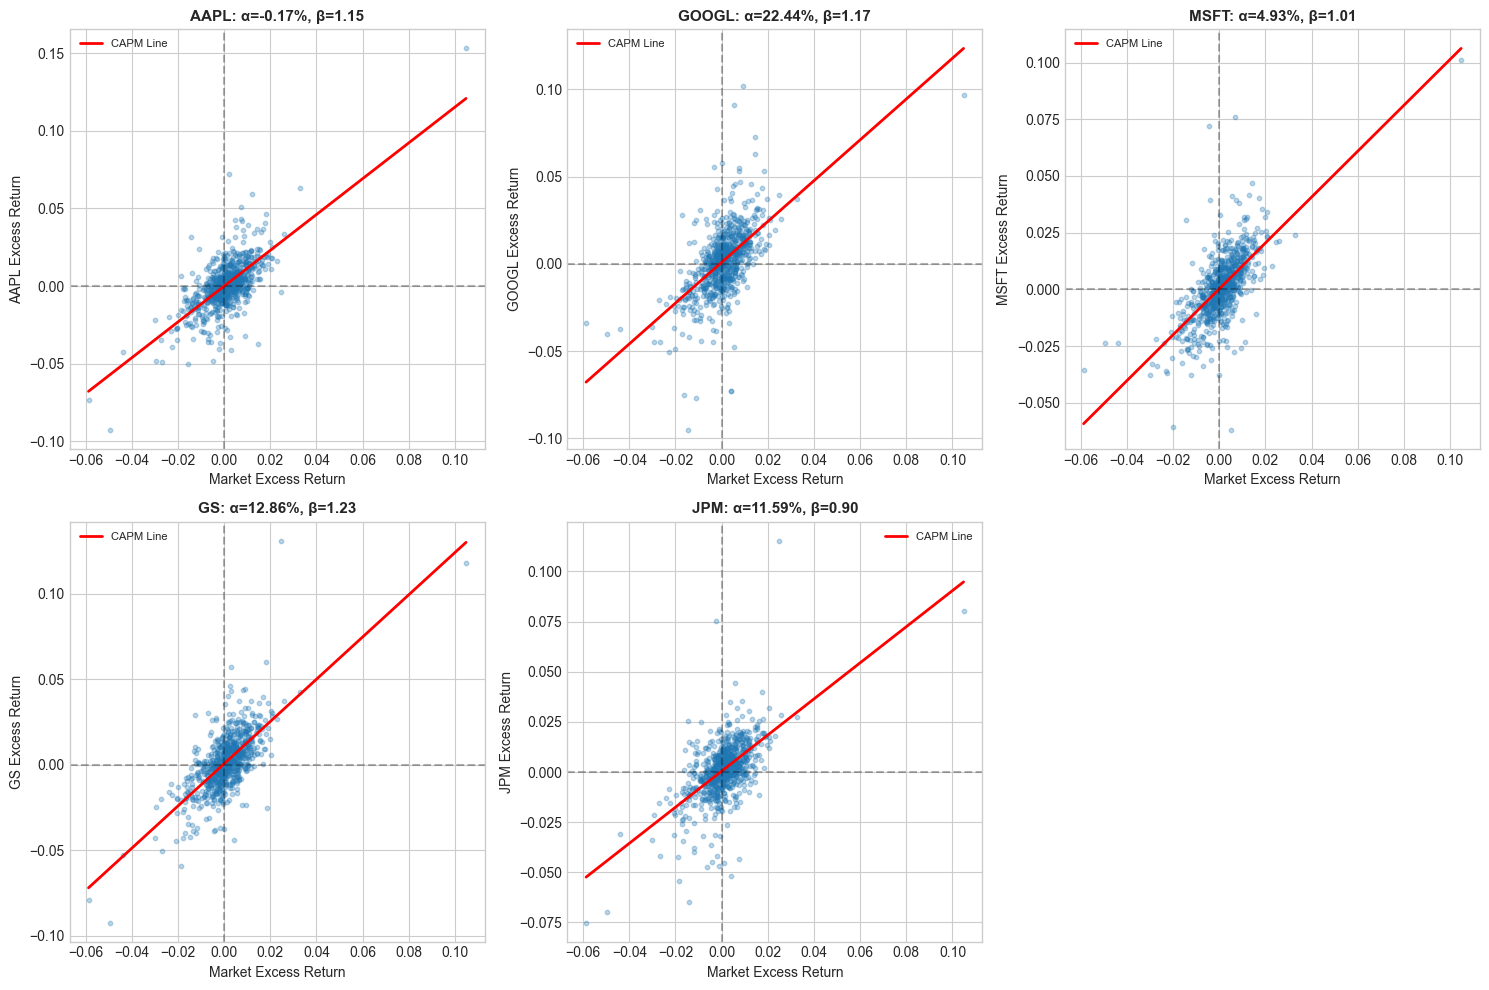

In [5]:
# ============================================================
# CAPM VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    
    excess_return = returns[ticker] - rf_daily
    
    ax.scatter(factors['Mkt-RF'], excess_return, alpha=0.3, s=10)
    
    # Regression line
    x_line = np.linspace(factors['Mkt-RF'].min(), factors['Mkt-RF'].max(), 100)
    y_line = capm_results[ticker]['alpha']/252 + capm_results[ticker]['beta'] * x_line
    ax.plot(x_line, y_line, 'r-', linewidth=2, label='CAPM Line')
    
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    ax.set_xlabel('Market Excess Return')
    ax.set_ylabel(f'{ticker} Excess Return')
    ax.set_title(f'{ticker}: α={capm_results[ticker]["alpha"]:.2%}, β={capm_results[ticker]["beta"]:.2f}', 
                fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

---

## 📊 Section 2: Fama-French 3-Factor Model (Week 6 Concept)

**FF3 Model:**
$$R_i - R_f = \alpha + \beta_1 (R_m - R_f) + \beta_2 SMB + \beta_3 HML + \epsilon$$

**Factors:**
- **Mkt-RF:** Market risk premium
- **SMB:** Small Minus Big (size factor)
- **HML:** High Minus Low (value factor)

In [6]:
# ============================================================
# FAMA-FRENCH 3-FACTOR MODEL
# ============================================================

print("📊 FAMA-FRENCH 3-FACTOR MODEL")
print("=" * 90)

ff3_results = {}

for ticker in TICKERS:
    excess_return = returns[ticker] - rf_daily
    
    # FF3 regression
    X = factors[['Mkt-RF', 'SMB', 'HML']].values
    y = excess_return.values
    
    model = LinearRegression()
    model.fit(X, y)
    
    alpha = model.intercept_ * 252  # Annualized
    betas = model.coef_
    
    # R-squared
    y_pred = model.predict(X)
    r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)
    
    ff3_results[ticker] = {
        'alpha': alpha,
        'beta_mkt': betas[0],
        'beta_smb': betas[1],
        'beta_hml': betas[2],
        'r2': r2
    }

print(f"\n{'Ticker':<10} {'Alpha':>10} {'β(Mkt)':>10} {'β(SMB)':>10} {'β(HML)':>10} {'R²':>10}")
print("-" * 90)
for ticker in TICKERS:
    r = ff3_results[ticker]
    print(f"{ticker:<10} {r['alpha']:>9.2%} {r['beta_mkt']:>9.2f} {r['beta_smb']:>9.2f} {r['beta_hml']:>9.2f} {r['r2']:>9.2%}")

📊 FAMA-FRENCH 3-FACTOR MODEL

Ticker          Alpha     β(Mkt)     β(SMB)     β(HML)         R²
------------------------------------------------------------------------------------------
AAPL          -0.08%      1.14      0.09     -0.02    47.54%
GOOGL         23.52%      1.14      0.10     -0.07    35.12%
MSFT           5.28%      1.00      0.03     -0.02    44.79%
GS            15.04%      1.22     -0.08     -0.11    48.03%
JPM           12.29%      0.89     -0.01     -0.04    35.03%


---

## 📊 Section 3: Fama-French 5-Factor Model (Week 6 Concept)

**FF5 Model adds:**
- **RMW:** Robust Minus Weak (profitability factor)
- **CMA:** Conservative Minus Aggressive (investment factor)

**More complete picture of systematic risk!**

In [7]:
# ============================================================
# FAMA-FRENCH 5-FACTOR MODEL
# ============================================================

print("📊 FAMA-FRENCH 5-FACTOR MODEL")
print("=" * 100)

ff5_results = {}

for ticker in TICKERS:
    excess_return = returns[ticker] - rf_daily
    
    # FF5 regression
    X = factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values
    y = excess_return.values
    
    model = LinearRegression()
    model.fit(X, y)
    
    alpha = model.intercept_ * 252  # Annualized
    betas = model.coef_
    
    # R-squared
    y_pred = model.predict(X)
    r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)
    
    ff5_results[ticker] = {
        'alpha': alpha,
        'beta_mkt': betas[0],
        'beta_smb': betas[1],
        'beta_hml': betas[2],
        'beta_rmw': betas[3],
        'beta_cma': betas[4],
        'r2': r2
    }

print(f"\n{'Ticker':<8} {'Alpha':>8} {'β(Mkt)':>8} {'β(SMB)':>8} {'β(HML)':>8} {'β(RMW)':>8} {'β(CMA)':>8} {'R²':>8}")
print("-" * 100)
for ticker in TICKERS:
    r = ff5_results[ticker]
    print(f"{ticker:<8} {r['alpha']:>7.2%} {r['beta_mkt']:>7.2f} {r['beta_smb']:>7.2f} {r['beta_hml']:>7.2f} {r['beta_rmw']:>7.2f} {r['beta_cma']:>7.2f} {r['r2']:>7.2%}")

📊 FAMA-FRENCH 5-FACTOR MODEL

Ticker      Alpha   β(Mkt)   β(SMB)   β(HML)   β(RMW)   β(CMA)       R²
----------------------------------------------------------------------------------------------------
AAPL      -0.45%    1.12    0.09   -0.02    0.14   -0.06  47.68%
GOOGL     22.36%    1.14    0.10   -0.07    0.17    0.12  35.28%
MSFT       4.51%    1.03    0.03   -0.02    0.00    0.21  44.97%
GS        15.13%    1.24   -0.08   -0.11   -0.08    0.07  48.07%
JPM       12.85%    0.90   -0.01   -0.04   -0.09   -0.05  35.10%


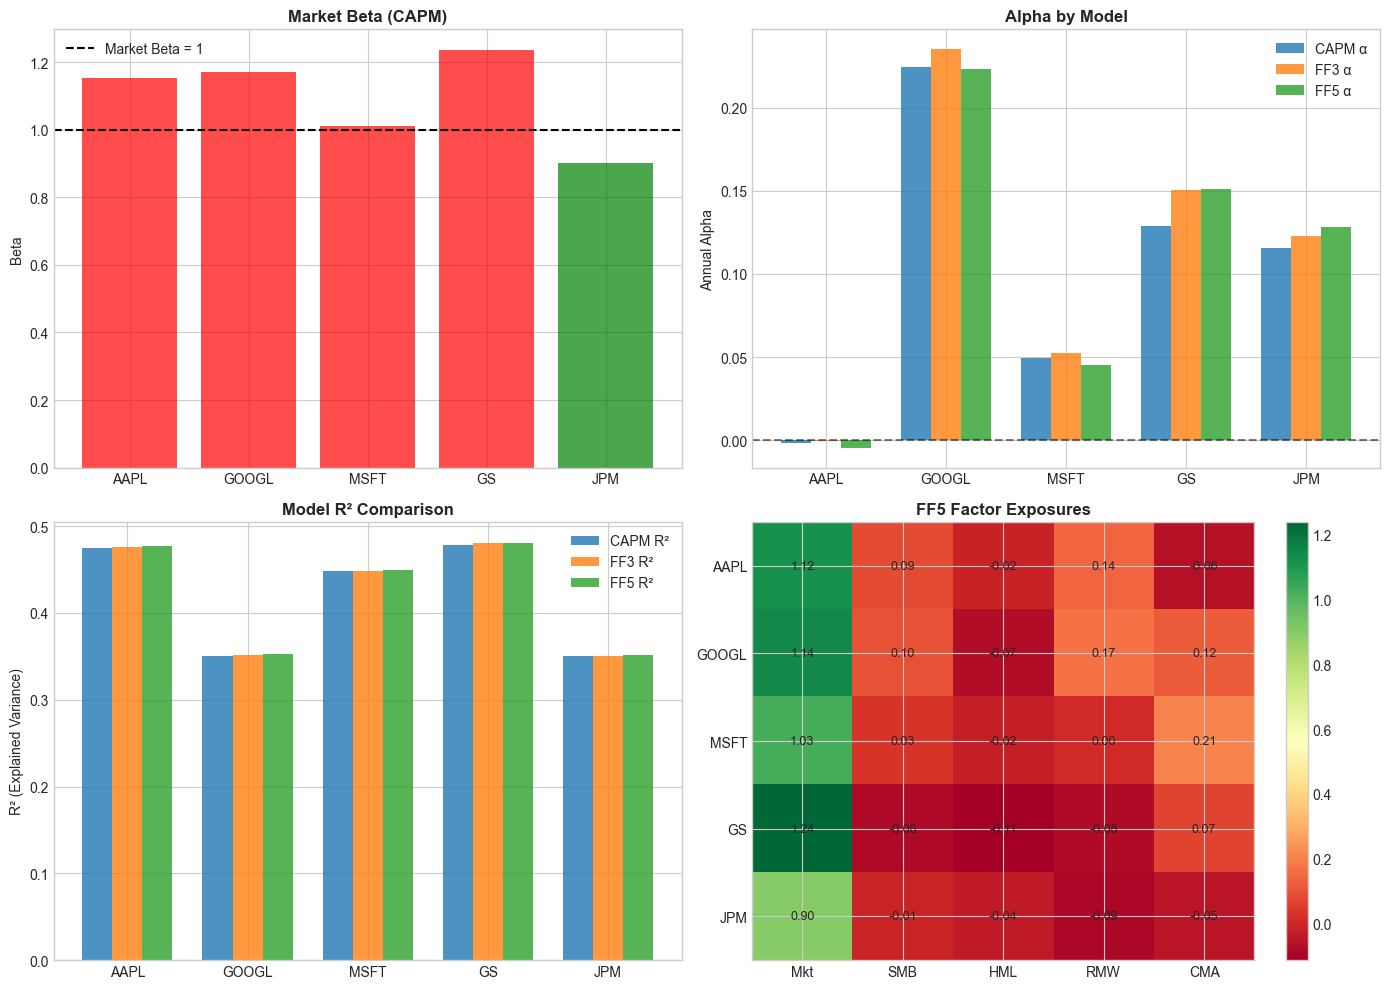

In [8]:
# ============================================================
# FACTOR EXPOSURE VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Market Beta Comparison
ax1 = axes[0, 0]
betas = [capm_results[t]['beta'] for t in TICKERS]
colors = ['green' if b < 1 else 'red' for b in betas]
ax1.bar(TICKERS, betas, color=colors, alpha=0.7)
ax1.axhline(y=1, color='k', linestyle='--', label='Market Beta = 1')
ax1.set_ylabel('Beta')
ax1.set_title('Market Beta (CAPM)', fontsize=12, fontweight='bold')
ax1.legend()

# 2. Alpha Comparison (CAPM vs FF3 vs FF5)
ax2 = axes[0, 1]
x = np.arange(len(TICKERS))
width = 0.25
ax2.bar(x - width, [capm_results[t]['alpha'] for t in TICKERS], width, label='CAPM α', alpha=0.8)
ax2.bar(x, [ff3_results[t]['alpha'] for t in TICKERS], width, label='FF3 α', alpha=0.8)
ax2.bar(x + width, [ff5_results[t]['alpha'] for t in TICKERS], width, label='FF5 α', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(TICKERS)
ax2.set_ylabel('Annual Alpha')
ax2.set_title('Alpha by Model', fontsize=12, fontweight='bold')
ax2.legend()
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# 3. R² Comparison (Model explains variance)
ax3 = axes[1, 0]
ax3.bar(x - width, [capm_results[t]['r2'] for t in TICKERS], width, label='CAPM R²', alpha=0.8)
ax3.bar(x, [ff3_results[t]['r2'] for t in TICKERS], width, label='FF3 R²', alpha=0.8)
ax3.bar(x + width, [ff5_results[t]['r2'] for t in TICKERS], width, label='FF5 R²', alpha=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(TICKERS)
ax3.set_ylabel('R² (Explained Variance)')
ax3.set_title('Model R² Comparison', fontsize=12, fontweight='bold')
ax3.legend()

# 4. FF5 Factor Exposures Heatmap
ax4 = axes[1, 1]
factor_exposures = pd.DataFrame({
    'Mkt': [ff5_results[t]['beta_mkt'] for t in TICKERS],
    'SMB': [ff5_results[t]['beta_smb'] for t in TICKERS],
    'HML': [ff5_results[t]['beta_hml'] for t in TICKERS],
    'RMW': [ff5_results[t]['beta_rmw'] for t in TICKERS],
    'CMA': [ff5_results[t]['beta_cma'] for t in TICKERS]
}, index=TICKERS)

im = ax4.imshow(factor_exposures.values, cmap='RdYlGn', aspect='auto')
ax4.set_xticks(range(len(factor_exposures.columns)))
ax4.set_yticks(range(len(TICKERS)))
ax4.set_xticklabels(factor_exposures.columns)
ax4.set_yticklabels(TICKERS)
ax4.set_title('FF5 Factor Exposures', fontsize=12, fontweight='bold')
for i in range(len(TICKERS)):
    for j in range(len(factor_exposures.columns)):
        ax4.text(j, i, f'{factor_exposures.iloc[i, j]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im, ax=ax4)

plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# FACTOR-BASED TRADING STRATEGY
# ============================================================

print("\n📊 FACTOR-BASED TRADING SIGNALS")
print("=" * 80)

# Strategy: Long high alpha, low beta stocks
# Score = Alpha - 0.5 * (Beta - 1)^2

factor_scores = {}
for ticker in TICKERS:
    alpha = ff5_results[ticker]['alpha']
    beta = ff5_results[ticker]['beta_mkt']
    
    # Prefer positive alpha, beta close to 1
    alpha_score = alpha * 100  # Scale
    beta_penalty = -0.5 * (beta - 1)**2 * 100
    
    total_score = alpha_score + beta_penalty
    
    factor_scores[ticker] = {
        'alpha_score': alpha_score,
        'beta_penalty': beta_penalty,
        'total_score': total_score,
        'signal': 'LONG' if total_score > 0 else 'SHORT' if total_score < -5 else 'NEUTRAL'
    }

print(f"\n{'Ticker':<10} {'Alpha Score':>15} {'Beta Penalty':>15} {'Total Score':>15} {'Signal':>12}")
print("-" * 80)
for ticker in TICKERS:
    s = factor_scores[ticker]
    signal_emoji = "📈" if s['signal'] == 'LONG' else ("📉" if s['signal'] == 'SHORT' else "⚪")
    print(f"{ticker:<10} {s['alpha_score']:>14.2f} {s['beta_penalty']:>14.2f} {s['total_score']:>14.2f} {signal_emoji} {s['signal']:>8}")


📊 FACTOR-BASED TRADING SIGNALS

Ticker         Alpha Score    Beta Penalty     Total Score       Signal
--------------------------------------------------------------------------------
AAPL                -0.45          -0.72          -1.17 ⚪  NEUTRAL
GOOGL               22.36          -1.00          21.35 📈     LONG
MSFT                 4.51          -0.03           4.48 📈     LONG
GS                  15.13          -2.86          12.26 📈     LONG
JPM                 12.85          -0.54          12.31 📈     LONG


In [10]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 6 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary
print("\n📋 FACTOR ANALYSIS SUMMARY:")
summary = pd.DataFrame({
    'CAPM Alpha': [capm_results[t]['alpha'] for t in TICKERS],
    'CAPM Beta': [capm_results[t]['beta'] for t in TICKERS],
    'FF5 Alpha': [ff5_results[t]['alpha'] for t in TICKERS],
    'FF5 R²': [ff5_results[t]['r2'] for t in TICKERS],
    'Factor Score': [factor_scores[t]['total_score'] for t in TICKERS],
    'Signal': [factor_scores[t]['signal'] for t in TICKERS]
}, index=TICKERS)

print(summary.round(4).to_string())

# Best picks
best_alpha = summary['FF5 Alpha'].idxmax()
best_score = summary['Factor Score'].idxmax()
lowest_beta = summary['CAPM Beta'].idxmin()

print("\n🏆 RECOMMENDATIONS:")
print(f"\n1. 📈 HIGHEST ALPHA: {best_alpha} (FF5 Alpha = {summary.loc[best_alpha, 'FF5 Alpha']:.2%})")
print(f"   → Stock generating excess returns above factor model predictions")

print(f"\n2. 🏆 BEST FACTOR SCORE: {best_score} (Score = {summary.loc[best_score, 'Factor Score']:.2f})")
print(f"   → Best combination of alpha and beta characteristics")

print(f"\n3. 🛡️ DEFENSIVE PICK: {lowest_beta} (Beta = {summary.loc[lowest_beta, 'CAPM Beta']:.2f})")
print(f"   → Lower market sensitivity, good for volatile markets")

# Long/Short signals
longs = [t for t in TICKERS if factor_scores[t]['signal'] == 'LONG']
shorts = [t for t in TICKERS if factor_scores[t]['signal'] == 'SHORT']

print(f"\n📈 LONG SIGNALS: {longs if longs else 'None'}")
print(f"📉 SHORT SIGNALS: {shorts if shorts else 'None'}")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 6 STRATEGY - FINAL RECOMMENDATIONS

📋 FACTOR ANALYSIS SUMMARY:
       CAPM Alpha  CAPM Beta  FF5 Alpha  FF5 R²  Factor Score   Signal
AAPL      -0.0017     1.1531    -0.0045  0.4768       -1.1683  NEUTRAL
GOOGL      0.2244     1.1698     0.2236  0.3528       21.3547     LONG
MSFT       0.0493     1.0116     0.0451  0.4497        4.4772     LONG
GS         0.1286     1.2347     0.1513  0.4807       12.2639     LONG
JPM        0.1159     0.9000     0.1285  0.3510       12.3126     LONG

🏆 RECOMMENDATIONS:

1. 📈 HIGHEST ALPHA: GOOGL (FF5 Alpha = 22.36%)
   → Stock generating excess returns above factor model predictions

2. 🏆 BEST FACTOR SCORE: GOOGL (Score = 21.35)
   → Best combination of alpha and beta characteristics

3. 🛡️ DEFENSIVE PICK: JPM (Beta = 0.90)
   → Lower market sensitivity, good for volatile markets

📈 LONG SIGNALS: ['GOOGL', 'MSFT', 'GS', 'JPM']
📉 SHORT SIGNALS: None

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-6)

| Week | Concept | Application |
|------|---------|-------------|
| 1 | Returns & Volatility | Factor calculations |
| 2 | Statistical Testing | Alpha significance |
| 3 | Time Series | Return series analysis |
| 4 | Linear Regression | Factor model fitting |
| 5 | Portfolio Theory | Factor-based allocation |
| **6** | **CAPM** | **Market risk analysis** |
| **6** | **Fama-French 3F** | **Size & Value factors** |
| **6** | **Fama-French 5F** | **Full factor model** |
| **6** | **Alpha & Beta** | **Trading signals** |

---